In [232]:
import sys
import time
import copy

from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
from gene_inference.models import lr, mlp, decision_tree
from gene_inference.infer_genes import infer_gene, infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference)

<module 'gene_inference' from 'gene_inference/__init__.pyc'>

In [2]:
#tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [3]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = True
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [4]:
graph = Graph()
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [57]:
# def pytorch_loop(dataset, method, seed, train_size, test_size, penalty=False, num_epochs=100, num_channel=None, num_layer=None, add_emb=None, use_gate=False, dropout=True, cuda=False, adj=None):
#     scores = []
   
#     labels = torch.LongTensor(dataset.labels)
#     criterions = otim.get_criterion(dataset)
#     train_ratio = float(train_size) / (2 * test_size + train_size)
#     train_set, valid_set, test_set = split_dataset(dataset, batch_size=10, random=True, train_ratio=train_ratio, seed=seed, nb_samples=train_size + 2 * test_size, nb_per_class=None)
#     patience = 20
#     opt.num_layer = num_layer
#     adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)
#     model = models.models.CGN(
#             nb_nodes=len(dataset.df.columns), 
#             input_dim=1,
#             channels=[num_channel] * num_layer,
#             adj=adj,
#             out_dim=2,
#             on_cuda=cuda,
#             add_emb=add_emb,
#             transform_adj=adj_transform,
#             aggregate_adj=aggregate_function,
#             use_gate=use_gate,
#             dropout=dropout,
#             )
#     if cuda:
#         torch.cuda.manual_seed(trial)
#         torch.cuda.manual_seed_all(trial)
#         model.cuda()

#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#     max_valid = 0
#     for t in range(0, num_epochs):
#         start_timer = time.time()
#         for no_b, mini in enumerate(train_set):
#             inputs, labels = mini['sample'], mini['labels']

#             inputs = Variable(inputs, requires_grad=False).float()
#             if cuda:
#                 inputs = inputs.cuda()
#                 labels = labels.cuda()

#             model.train()
#             y_pred = model(inputs)

#             # Compute and print loss
#             crit_loss = otim.compute_loss(criterions, y_pred, labels)
#             total_loss = crit_loss

#             # Zero gradients, perform a backward pass, and update the weights.
#             optimizer.zero_grad()
#             crit_loss.backward()
#             optimizer.step()
#             model.eval()
#         time_this_epoch = time.time() - start_timer
        
        
#         acc = {}
#         auc = {}
#         for my_set, set_name in zip([train_set, valid_set], ['train', 'valid']):
#             acc[set_name] = accuracy(my_set, my_model, on_cuda=cuda)
#             auc[set_name] = auc(my_set, my_model, on_cuda=cuda)
        
        
#         acc, auc = record_metrics_for_epoch(None, crit_loss, total_loss, t, time_this_epoch, train_set, valid_set, test_set, model, dataset, cuda=True)
#         summary = [
#             t,
#             crit_loss.data[0],
#             acc['train'],
#             acc['valid'],
#             auc['train'],
#             auc['valid'],
#             time_this_epoch
#         ]
#         summary = "epoch {}, cross_loss: {:.03f}, acc_train: {:0.3f}, acc_valid: {:0.3f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
#         print summary

#         patience = patience - 1
#         if patience == 0:
#             break
#         if max_valid < auc['valid']:
#             max_valid = auc['valid']
#         if max_valid > auc['valid'] and t > 15:
#             scores.append(auc['test']) 
#             break

#     return np.round(np.mean(scores), 2),  np.round(np.std(scores), 2)

In [461]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=64, num_layer=3, add_emb=32, use_gate=False, dropout=True, cuda=True):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.60, random_state=seed)
    
    
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        
        patience = 20
        opt.num_layer = self.num_layer
        adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)
        model = models.models.CGN(
                nb_nodes=len(dataset.df.columns), 
                input_dim=1,
                channels=[self.num_channel] * self.num_layer,
                adj=adj,
                out_dim=2,
                on_cuda=self.cuda,
                add_emb=self.add_emb,
                transform_adj=adj_transform,
                aggregate_adj=aggregate_function,
                use_gate=self.use_gate,
                dropout=self.dropout,
                )
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            if self.cuda:
                model.cuda()
                model.on_cuda = True
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels)
                total_loss = crit_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()
            time_this_epoch = time.time() - start_timer
            
            
            auc = {}
            if self.cuda:
                model.cpu()
                model.on_cuda = False

            auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            print summary

            patience = patience - 1
            if patience == 0:
                break
            if max_valid < auc['valid']:
                max_valid = auc['valid']
            if max_valid > auc['valid'] and t > 15:
                #scores.append(auc['test']) 
                return auc['test']
                break

In [463]:
lines = []
def method_comparison(results, dataset, models, gene, max_genes, trials, train_size, test_size):
    
    dataset = data.gene_datasets.TCGATissue()
    dataset.df = dataset.df - dataset.df.mean()
    
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    full_df = dataset.df.copy(deep=True)
    
    print "Max ex ", int(np.log2(max_genes))+1
    for ex in range(4, int(np.log2(max_genes))+1):
        
        num_genes = 2**ex
        num_genes = np.min([num_genes, tcgatissue.df.shape[1]])
        print ex, num_genes
        
        neighbors = sample_neighbors(g, gene, num_genes, include_self=False)
        print "neighbors", len(neighbors)
        
        if gene in neighbors:
            neighbors.remove(gene)

        dataset.df = dataset.df[list(neighbors)]
        dataset.data = dataset.df.as_matrix()
        
        neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
        
        for model in models:
            for seed in range(trials):
            
                #have we already done it?
                already_done = results["df"][(results["df"].gene_name == gene) & 
                                             (results["df"].model == model['key']) &
                                             (results["df"].num_genes == num_genes) &
                                             (results["df"].seed == seed) &
                                             (results["df"].train_size == train_size)].shape[0] > 0

                if already_done:
                    print "already done:", model['key'], num_genes, seed
                    continue
                print "doing:", model['key'], num_genes, seed

                result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

                experiment = {"gene_name": gene,
                        "model": model['key'],
                        "num_genes": num_genes, 
                        "seed":seed,
                        "train_size": train_size,
                        "auc":result
                        }

                results["df"] = results["df"].append(experiment, ignore_index=True)
        dataset.df = full_df
    

In [464]:
import data
reload(data)
reload(models.models)
reload(gene_inference)
reload(gene_inference.models)
reload(analysis.metrics)

m = [
#    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
#    {'key': 'DT', 'method': SkLearn("DT")},
   {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
    ]



In [457]:
#results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [ ]:
method_comparison(results, tcgatissue, m, gene="RPL5", max_genes=10000, trials=3, train_size=100, test_size=1000)

Converting one-hot labels to integers
Max ex  14
4 16
neighbors 16
already done: CGN_3_layer_64_channel_emb_32_dropout 16 0
already done: CGN_3_layer_64_channel_emb_32_dropout 16 1
already done: CGN_3_layer_64_channel_emb_32_dropout 16 2
5 32
neighbors 32
already done: CGN_3_layer_64_channel_emb_32_dropout 32 0
already done: CGN_3_layer_64_channel_emb_32_dropout 32 1
already done: CGN_3_layer_64_channel_emb_32_dropout 32 2
6 64
neighbors 64
already done: CGN_3_layer_64_channel_emb_32_dropout 64 0
already done: CGN_3_layer_64_channel_emb_32_dropout 64 1
already done: CGN_3_layer_64_channel_emb_32_dropout 64 2
7 128
neighbors 128
already done: CGN_3_layer_64_channel_emb_32_dropout 128 0
already done: CGN_3_layer_64_channel_emb_32_dropout 128 1
already done: CGN_3_layer_64_channel_emb_32_dropout 128 2
8 256
neighbors 256
already done: CGN_3_layer_64_channel_emb_32_dropout 256 0
already done: CGN_3_layer_64_channel_emb_32_dropout 256 1
already done: CGN_3_layer_64_channel_emb_32_dropout 25

In [223]:
import pickle
#pickle.dump(results, open("results.pkl", "wb"))

In [432]:
results = pickle.load(open("results.pkl", "r"))

In [459]:
results["df"]

,auc,gene_name,model,num_genes,seed,train_size
0,0.607299,RPL5,LR,16,0,100
1,0.600154,RPL5,DT,16,0,100
2,0.668459,RPL5,LR,32,0,100
3,0.588687,RPL5,DT,32,0,100
4,0.814841,RPL5,LR,64,0,100
5,0.803318,RPL5,DT,64,0,100
6,0.826276,RPL5,LR,128,0,100
7,0.781280,RPL5,DT,128,0,100
8,0.841231,RPL5,LR,256,0,100
9,0.776743,RPL5,DT,256,0,100


In [460]:
results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].agg(['mean','std'])

mean       std
gene_name model                                 num_genes                    
RPL5      CGN_3_layer_64_channel_emb_32_dropout 16         0.630071  0.006289
                                                32         0.687780  0.035461
                                                64         0.914718  0.013750
                                                128        0.917464  0.012301
                                                256        0.919831  0.012220
                                                512        0.919843       NaN
          DT                                    16         0.579611  0.014951
                                                32         0.608420  0.025379
                                                64         0.805997  0.005819
                                                128        0.801461  0.018177
                                                256        0.786899  0.027143
                                                512        0.768571  0.026808
                                                1024       0.803318       NaN
                                                2048       0.809767       NaN
                                                4096       0.805918       NaN
                                                8192       0.735300       NaN
          LR                                    16         0.624160  0.023844
                                                32         0.696922  0.040253
                                                64         0.829192  0.020296
                                                128        0.840371  0.019934
                                                256        0.854963  0.019419
                                                512        0.844420  0.026068
                                                1024       0.810111       NaN
                                                2048       0.765276       NaN
                                                4096       0.734188       NaN
                                                8192       0.727042       NaN
          LR-L1                                 16         0.615286  0.024714
                                                32         0.702527  0.020841
                                                64         0.844253  0.013111
                                                128        0.837101  0.005798
                                                256        0.834441  0.010177
                                                512        0.811393  0.021832

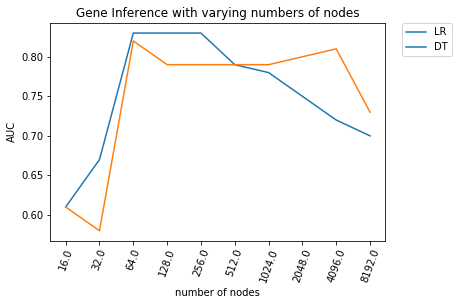

In [33]:
%matplotlib inline
plt.figure()
titles = []
labels = ["LR","DT"]
for i,model in enumerate([results_df_lr, results_df_dt]):
    temp_results = model
    lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
    titles.append(labels[i])
    plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
width = 0.2
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
#results_df = pd.DataFrame(columns=['model', 'num_genes', 'gene_name', 'auc', 'std'])
#results_df = results_df.append(data=pd.DataFrame(pd.DataFrame(data={'model':"LR", 'num_genes': 10.0, 'gene_name': "RPL5", 'auc':0.57, 'std': 0.01}, index=[0]))
len(["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"])
len([10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0])
len([0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92])
len([0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00])
results_df = pd.DataFrame(data={'model':["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"],
                   'num_genes': [10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0],
#                  'gene_name': ["RPL5", "RPL5"],
                   'auc': [0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92],
                   'std': [0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00]}, index=range(0, 28))
plt.figure()
titles = []
for model in [
    {'key': 'LR', 'method': lr},
    {'key': 'MLP', 'method': mlp},
    {'key': 'Decision Tree', 'method': decision_tree},
    {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': cgn_loop, 'num_channel': 64, 'num_layer': 3, 'add_emb': 32, 'use_gate': False, 'dropout': True, 'cuda': True},
    ]:
    temp_results = results_df.loc[results_df['model'] == model['key']].reset_index(drop=True)
    lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
    titles.append(model['key'])
    plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
width = 0.2
plt.title("Inferring the value of RPL5 with varying numbers of genes")
plt.ylabel("AUC")
plt.xlabel("# genes")
plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# Predict a gene from a growing number of Nodes
lr_results = pd.DataFrame([])
mlp_results = pd.DataFrame([])
cgn_results = pd.DataFrame([])
gene = "RPL5"
max_samples = 200
reload(data)
reload(models)
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')

for num_samples in range(10, max_samples, 20):
    lr_row = infer_gene(lr, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    lr_results = lr_results.append(lr_row).reset_index(drop=True)
    lr_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    cgn_row = infer_gene(cgn, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    cgn_results = cgn_results.append(cgn_row).reset_index(drop=True)
    cgn_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    print num_genes
    print cgn_results
    print lr_results

In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_samples'], rotation=70)
plt.title("Gene Inference with varying numbers of samples")
plt.ylabel("AUC")
plt.xlabel("number of samples")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)